In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

con = sqlite3.connect("n1_data.db")

print(con.total_changes)

0


In [9]:
cur = con.cursor()

#Create main table
cur.execute("CREATE TABLE std_member_info (member_id INTEGER, member_first_name TEXT, member_last_name TEXT, date_of_birth TEXT, main_address TEXT, city TEXT, state TEXT, zip_code INTEGER, payer TEXT)")

#roster_2 copy for date formatting
cur.execute("CREATE TABLE r_2 (member_id INTEGER, member_first_name TEXT, member_last_name TEXT, date_of_birth TEXT, main_address TEXT, city TEXT, state TEXT, zip_code INTEGER, payer TEXT, eligibility_start_date TEXT, eligibility_end_date TEXT)")

#roster_4 copy for state formatting
cur.execute("CREATE TABLE r_4 (member_id INTEGER, member_first_name TEXT, member_last_name TEXT, date_of_birth TEXT, main_address TEXT, city TEXT, state TEXT, zip_code INTEGER, payer TEXT, eligibility_start_date TEXT, eligibility_end_date TEXT)")


In [10]:
#Data Standardization

cur.execute("INSERT INTO r_2 SELECT Person_Id, First_Name, Last_Name, (substr(Dob, 7, 4) || '-' ||  substr(Dob, -10, 2) || '-' || substr(Dob, 4, 2)), Street_Address, City, State, Zip, payer, (substr(eligibility_start_date, 7, 4) || '-' ||  substr(eligibility_start_date, -10, 2) || '-' || substr(eligibility_start_date, 4, 2)), (substr(eligibility_end_date, 7, 4) || '-' ||  substr(eligibility_end_date, -10, 2) || '-' || substr(eligibility_end_date, 4, 2)) FROM roster_2")

#check r_2
rows = cur.execute("SELECT eligibility_end_date FROM r_2").fetchall()
print(len(rows))
#print(rows)


23392


In [8]:
#Drop Tables [ONLY FOR TESTING]
cur.execute("DROP TABLE std_member_info")
cur.execute("DROP TABLE r_2")
cur.execute("DROP TABLE r_4")

In [11]:
#Data Standardization
cur.execute("INSERT INTO r_4 SELECT Person_Id, First_Name, Last_Name, Dob, Street_Address, City, 'California', Zip, payer, eligibility_start_date, eligibility_end_date FROM roster_4")

#check r_4
rows = cur.execute("SELECT state FROM r_4").fetchall()
print(len(rows))
#print(rows)

22900


In [12]:
cur.execute("CREATE TABLE temp (member_id INTEGER, member_first_name TEXT, member_last_name TEXT, date_of_birth TEXT, main_address TEXT, city TEXT, state TEXT, zip_code INTEGER, payer TEXT, eligibility_start_date TEXT, eligibility_end_date TEXT)")

#default tables
cur.execute("INSERT INTO temp SELECT Person_Id, First_Name, Last_Name, Dob, Street_Address, City, State, Zip, payer, eligibility_start_date, eligibility_end_date FROM roster_1")
cur.execute("INSERT INTO temp SELECT Person_Id, First_Name, Last_Name, Dob, Street_Address, City, State, Zip, payer, eligibility_start_date, eligibility_end_date FROM roster_3")
cur.execute("INSERT INTO temp SELECT Person_Id, First_Name, Last_Name, Dob, Street_Address, City, State, Zip, payer, eligibility_start_date, eligibility_end_date FROM roster_5")

#cur.execute("CREATE TABLE r_2 (member_id INTEGER, member_first_name TEXT, member_last_name TEXT, date_of_birth TEXT, main_address TEXT, city TEXT, state TEXT, zip_code INTEGER, payer TEXT, eligibility_start_date TEXT, eligibility_end_date TEXT)")

#altered tables
cur.execute("INSERT INTO temp SELECT member_id, member_first_name, member_last_name, date_of_birth, main_address, city, state, zip_code, payer, eligibility_start_date, eligibility_end_date FROM r_2")
cur.execute("INSERT INTO temp SELECT member_id, member_first_name, member_last_name, date_of_birth, main_address, city, state, zip_code, payer, eligibility_start_date, eligibility_end_date FROM r_4")



In [99]:
#TESTING ONLY
cur.execute("DROP TABLE temp")

In [13]:
#Check Temp Table
rows = cur.execute("SELECT member_id FROM temp").fetchall()
print(len(rows))

142305


In [17]:
#Populate final table
cur.execute("INSERT INTO std_member_info SELECT DISTINCT member_id, member_first_name, member_last_name, date_of_birth, main_address, city, state, zip_code, payer FROM temp HERE eligibility_end_date > '2022-04-30' AND eligibility_start_date < '2022-04-01'")


In [110]:
#a. How many distinct members are eligible in April 2022?
distinct_members = cur.execute("SELECT member_id FROM std_member_info").fetchall()

print("There are {:,} distinct members eligible in April 2022.".format(len(distinct_members)))


There are 86,418 distinct members eligible in April 2022.


In [127]:
#b. How many members were included more than once?
#NOTE: Checked that there were no triple repeats using sets
total_members = cur.execute("SELECT member_id FROM temp WHERE eligibility_end_date > '2022-04-30' AND eligibility_start_date < '2022-04-01'").fetchall()

print("Across the 5 rosters, there are {:,} total listed members eligible in April 2022. Accounting for the number of distinct members listed above, there were {:,} members included more than once.".format(len(total_members), len(total_members) - len(distinct_members)))


Across the 5 rosters, there are 109,213 total listed members eligible in April 2022. Accounting for the number of distinct members listed above, there were 22,795 members included more than once.


In [111]:
#c. What is the breakdown of members by payer?
Madv = cur.execute("SELECT member_id FROM std_member_info WHERE payer = 'Madv'").fetchall()
Mdcd = cur.execute("SELECT member_id FROM std_member_info WHERE payer = 'Mdcd'").fetchall()

print("{:,} members, {:.2%} of those eligible, use Mdcd as their payer. The other {:2,} members use Madv.".format(len(Mdcd), (len(Mdcd)/len(distinct_members)), len(Madv)))


54,071 members, 62.57% of those eligible, use Mdcd as their payer. The other 32,347 members use Madv.


In [126]:
#d. How many members live in a zip code with a food_access_score lower than 2?
members_fas = cur.execute("SELECT member_id FROM std_member_info WHERE zip_code IN (SELECT zcta FROM model_scores_by_zip WHERE food_access_score < 2)").fetchall()

print("{:,} members live in zip codes with a food_access_code lower than 2.".format(len(members_fas)))


6,676 members live in zip codes with a food_access_code lower than 2.


In [125]:
#e. What is the average social isolation score for the members?
res = cur.execute("SELECT std_member_info.member_id, std_member_info.zip_code, model_scores_by_zip.social_isolation_score FROM std_member_info LEFT JOIN model_scores_by_zip ON std_member_info.zip_code = model_scores_by_zip.zcta ORDER BY std_member_info.zip_code").fetchall()
scores = [element[2] for element in res]

si_score = sum(scores)/(len(res))

print("The average social isolation score for the members is {:.4f}".format(si_score))


The average social isolation score for the members is 3.0677


In [124]:
#f. Which members live in the zip code with the highest algorex_sdoh_composite_score?

high = cur.execute("SELECT * FROM model_scores_by_zip WHERE algorex_sdoh_composite_score = (SELECT MAX(algorex_sdoh_composite_score) FROM model_scores_by_zip)").fetchall()
zc = high[0][0]
members_sdoh = cur.execute("SELECT ('2022' - date_of_birth), date_of_birth, zip_code, payer FROM std_member_info WHERE zip_code = (SELECT zcta FROM model_scores_by_zip WHERE algorex_sdoh_composite_score = (SELECT MAX(algorex_sdoh_composite_score) FROM model_scores_by_zip ORDER BY zcta))").fetchall()


ages = [element[0] for element in members_sdoh]

#switch to a mean function?
avg_age = sum(ages)/len(ages)

#add in payer info or any other model scores?
print("There are {} members who live in zip code {}, the zip code with the highest algorex_sdoh_composite_score. Their average age as of 2023-01-01 is {:.2f} years old.".format(len(members_sdoh), zc, avg_age))



There are 38 members who live in zip code 95950, the zip code with the highest algorex_sdoh_composite_score. Their average age as of 2023-01-01 is 53.05 years old.


Text(0.5, 1.0, 'Housing and Social Support')

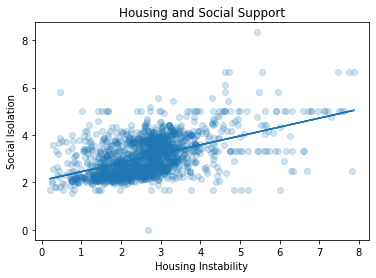

In [123]:
#Visualization
import numpy as np
d = cur.execute("SELECT zcta, unstable_housing_score, social_isolation_score FROM model_scores_by_zip").fetchall()

zips = [element[0] for element in d]
housing = [element[1] for element in d]
isolation = [element[2] for element in d]

#create scatter
plt.scatter(housing, isolation, alpha = 0.2)

z = np.polyfit(housing, isolation, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(housing, p(housing))

#labels
plt.xlabel("Housing Instability")
plt.ylabel("Social Isolation")
plt.title("Housing and Social Support")

1760
1760
50.0115846757353


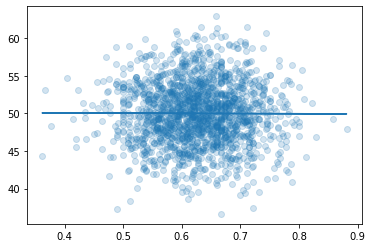

In [115]:
#Experimenting with other visualizations, used age data for 3f

ages = cur.execute("SELECT AVG('2022' - date_of_birth), AVG(payer = 'Mdcd'), zip_code FROM std_member_info GROUP BY zip_code ORDER BY 1").fetchall()

scores = cur.execute("SELECT algorex_sdoh_composite_score, zcta FROM model_scores_by_zip ORDER BY zcta").fetchall()


a = [element[0] for element in ages]
print(sum(a)/len(ages))
medi = [element[1] for element in ages]
sdoh = [element[0] for element in scores]

plt.scatter(medi, a, alpha = 0.2)

z = np.polyfit(medi, a, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(medi, p(medi))

